In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from Classes.Domain import layer_3
from Classes.TypesInstant import RecordInfo
from Classes.ExtractSplice import ExtractSplice
from Classes.Func.KitTools import TimeShift, ConfigRead
from Classes.Func.DiagramsGen import PlotMain
from Classes.Func.CalculatePart import FreqPreMethod

In [2]:
file_name = r'C:\Users\HY_Burger\Desktop\Project\extube_sump12.csv'
data_loc = Path(ConfigRead('WaveData', 'Extube'))
vm_list = ['SPONT', 'CPAP', 'APNEA VENTILATION']
df_main = pd.read_csv(file_name)
df_main.endo_end = np.where(df_main.endo_end.str.contains('成功'), 0, 1)
TimeShift(df_main, ['endo_t', 'END_t', 'Resp_t'])
gp_main = df_main.groupby('PID')

In [3]:
def PatientGen(gp, pid):
    df = gp.get_group(pid)
    df = df.reset_index(drop=True)
    rid = df.Record_id.unique()[0]
    pid_obj = layer_3.Patient()
    pid_obj.pid = pid
    pid_obj.end_t = df.endo_t[0]
    pid_obj.end_i = df.endo_end.unique()[0]
    rid_p = RecordInfo(data_loc, pid_obj.end_t, rid)
    rid_p.ParametersInit()
    pid_obj.ridrec = rid_p.rec
    return pid_obj
def RecordGet(gp, pid):
    id_list = gp.get_group(pid).zdt_1.tolist()
    pid_obj = PatientGen(gp, pid)
    process_0 = ExtractSplice(pid_obj.ridrec)
    process_0.RecBatchesExtract(id_list, 1800)
    pid_obj.resp_l = process_0.RespSplicing(1800, vm_list)
    return pid_obj.resp_l

In [4]:
# 1157905 3140128
resp_l = RecordGet(gp_main,3140128)
rr = np.array([i.rr for i in resp_l])
v_t = np.array([i.v_t_i for i in resp_l])
ve = np.array([i.ve for i in resp_l])
wob = np.array([i.wob for i in resp_l])
wid_l = [round(i.wid) for i in resp_l]
t_ind = np.array([sum(wid_l[0:i])for i in range(len(wid_l))])
df = pd.DataFrame({'t_ind':t_ind,'rr':rr, 'v_t':v_t, 've':ve, 'wob':wob})
len(df)

455

ReSample Processing

In [5]:
resp_clip = slice(200,300,1)
interp_rate = 100
re_rate = 4

In [6]:
rs_p = FreqPreMethod(df.t_ind, df.rr, resp_clip)
rs_p.InterpValue(interp_rate)
rs_p.Resampling(re_rate)
pl_P = PlotMain()
pl_P.lmplot('time', 'value', rs_p.df, 'RR Trend')

KeyError: "['time'] not in index"

In [7]:
L = 240
v_a = rs_p.df.value
v_s_l = []
ac_anchor = lambda x,y: True if x[y] > x[y-1] else False
dc_anchor = lambda x,y: True if x[y] < x[y-1] else False
for i in range(L, len(v_a)-L):
    if not ac_anchor(v_a, i):
        pass
    else:
        clip = slice(i-L, i+L+1)
        v_s = v_a[clip].tolist()
        v_s_l.append(v_s)

x_axis = np.linspace(-L, L+1, 2*L+1, endpoint=False)

KeyError: 240

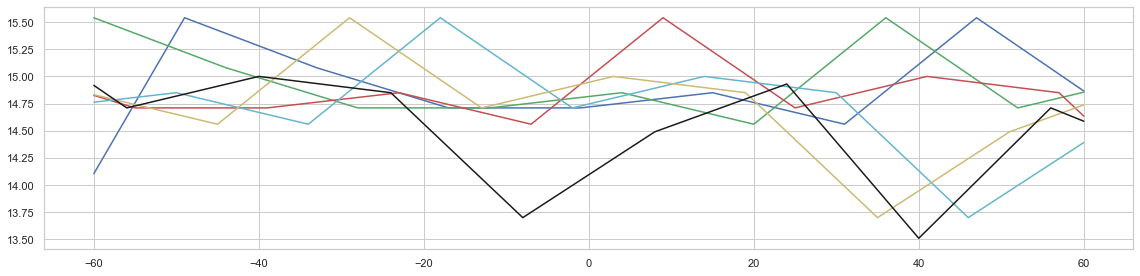

In [ ]:
from matplotlib import pyplot as plt
color_set = ['b-', 'g-', 'r-', 'c-', 'y-', 'k-']
plt.figure(figsize=(16,4))
for i in range(len(color_set)):
    plt.plot(x_axis,v_s_l[i+i*10],color_set[i])
plt.tight_layout()
plt.show()

In [ ]:
v_prsa = np.array([np.mean(i) for i in np.array(v_s_l).T])
df_prsa = pd.DataFrame({'time':x_axis, 'value':v_prsa})

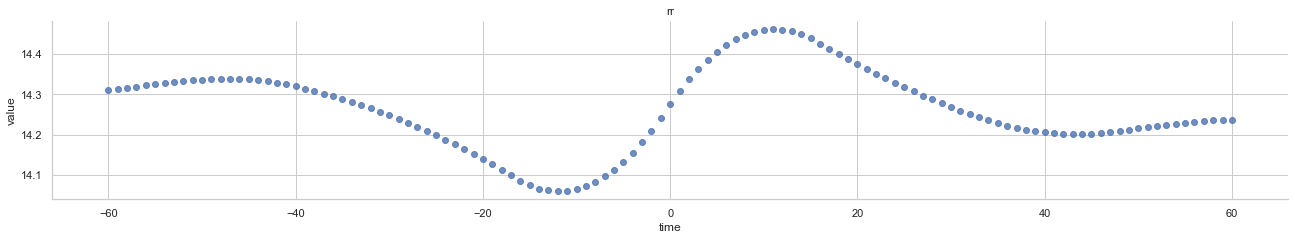

In [ ]:
pl_P.lmplot('time', 'value', df_prsa, 'rr')

In [ ]:
ac_l= np.array([df_prsa.value[df_prsa.time == i] for i in [-2, -1, 0, 1]])
ac_conv = (ac_l[2] + ac_l[3] - ac_l[1] - ac_l[0]) / 4
round(ac_conv.item(), 4)

0.0335

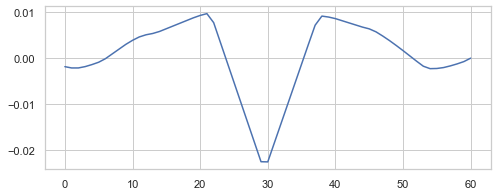

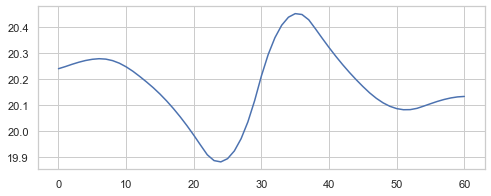

In [ ]:
import pywt
cA, cD = pywt.dwt(df_prsa.value, 'haar')
plt.figure(figsize=(8,3))
plt.plot(cD)
plt.show()
wave = pywt.idwt(cA, cD, wavelet='haar')
plt.figure(figsize=(8,3))
plt.plot(cA)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
df_out = pd.read_csv('outcome.csv')

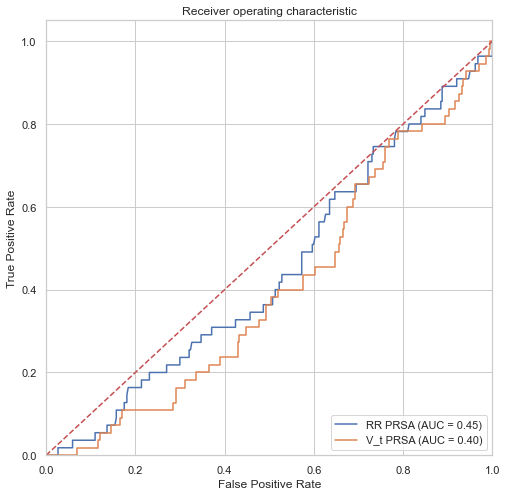

In [ ]:
roc_auc_rr = roc_auc_score(df_out.op_end, df_out.rr)
fpr_rr, tpr_rr, _ = roc_curve(df_out.op_end, df_out.rr)
roc_auc_vt = roc_auc_score(df_out.op_end, df_out.v_t)
fpr_vt, tpr_vt, _ = roc_curve(df_out.op_end, df_out.v_t)
fig_dims = (8, 8)
plt.subplots(figsize=fig_dims)
plt.plot(fpr_rr, tpr_rr, label='RR PRSA (AUC = %0.2f)' % roc_auc_rr)
plt.plot(fpr_vt, tpr_vt, label='V_t PRSA (AUC = %0.2f)' % roc_auc_vt)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()